## 1. Business Understanding

This project will analyze customer reviews of Amazon's electronic products to identify the key drivers of customer satisfaction and dissatisfaction. By understanding what customers love and hate about our products, we can provide actionable insights to:

*   **Product Development:** Pinpoint specific features that need improvement and identify new features that customers desire.
*   **Marketing:** Craft more effective marketing messages that highlight the features customers love the most.
*   **Quality Assurance:** Identify products with recurring quality issues.

The ultimate goal is to improve product quality, increase customer satisfaction, and boost sales.

## 2. Data Understanding

I chose to use [Consumer Reviews of Amazon Products](https://www.kaggle.com/datasets/datafiniti/consumer-reviews-of-amazon-products) from Kaggle because it contains a lot of the review from the customers. It also contain some important featues, such as categories of the product, manufaturer of the product and the rating, which is really helpful for sentiment analytics and further exploration. Unfortunately, after exaim this dataset, it only contains review which related to technical product, and only include the product manufacture by Amazon, I think it'll be the biggest hindrance when using this dataset for analyze

### Import for datas preprossing and EDA

In [5]:
import kagglehub
import pandas as pd
import numpy as np
import os
import re
from nltk.corpus import stopwords
from collections import Counter

import plotly.graph_objects as go
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


In [6]:
path = kagglehub.dataset_download("datafiniti/consumer-reviews-of-amazon-products")
df1 = pd.read_csv(os.path.join(path, '1429_1.csv'), low_memory=False)
df2 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'))
df3 = pd.read_csv(os.path.join(path, 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'))

The original dataset from Kaggle be divided to three sperate csv file, after concate it, it include the following features and information. Here is a quick overview:

In [7]:
master_df = pd.concat([df1, df2, df3], ignore_index=True)
master_df.to_csv('amazon_reviews_master.csv')
master_df.info()
master_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67992 entries, 0 to 67991
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    67992 non-null  object 
 1   name                  61232 non-null  object 
 2   asins                 67990 non-null  object 
 3   brand                 67992 non-null  object 
 4   categories            67992 non-null  object 
 5   keys                  67992 non-null  object 
 6   manufacturer          67992 non-null  object 
 7   reviews.date          67953 non-null  object 
 8   reviews.dateAdded     25091 non-null  object 
 9   reviews.dateSeen      67992 non-null  object 
 10  reviews.didPurchase   10 non-null     object 
 11  reviews.doRecommend   55152 non-null  object 
 12  reviews.id            71 non-null     float64
 13  reviews.numHelpful    55246 non-null  float64
 14  reviews.rating        67959 non-null  float64
 15  reviews.sourceURLs 

id                          0
name                     6760
asins                       2
brand                       0
categories                  0
keys                        0
manufacturer                0
reviews.date               39
reviews.dateAdded       42901
reviews.dateSeen            0
reviews.didPurchase     67982
reviews.doRecommend     12840
reviews.id              67921
reviews.numHelpful      12746
reviews.rating             33
reviews.sourceURLs          0
reviews.text                1
reviews.title              19
reviews.userCity        67992
reviews.userProvince    67992
reviews.username           13
dateAdded               34660
dateUpdated             34660
primaryCategories       34660
imageURLs               34660
manufacturerNumber      34660
sourceURLs              34660
dtype: int64

We can see all the columns and their missing values in the result above

### 3. Data Preparation & Exploratory Data Analysis (EDA)

In [8]:
master_df.isna().sum()
master_df.duplicated().sum()

np.int64(95)

#### - Drop unrelated features and duplicate values

In [9]:
df_cleaned = master_df.copy()

In [10]:
df_cleaned.drop_duplicates(subset=['reviews.username', 'reviews.text', 'reviews.rating'], inplace=True)

In [11]:
# Define the columns to drop
columns_to_drop = [
    'reviews.userCity',
    'reviews.userProvince',
    'reviews.id',
    'reviews.didPurchase',
    'reviews.dateAdded',
    'id',
    'asins',
    'keys',
    'manufacturer',
    'reviews.sourceURLs',
    'sourceURLs',
    'imageURLs',
    'manufacturerNumber',
    'dateAdded',
    'dateUpdated'
]

df_cleaned.drop(columns=columns_to_drop, inplace=True)

#### - Drop missing value & chage the data type

In [12]:
# Drop rows where essential data is missing
df_cleaned.dropna(subset=['reviews.rating', 'reviews.text', 'reviews.title', 'reviews.username', 'reviews.date', 'reviews.doRecommend'], inplace=True)
df_cleaned['primaryCategories'] = df_cleaned['primaryCategories'].fillna('Unknown')
df_cleaned['name'] = df_cleaned['name'].fillna('Unknown')
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'], errors='coerce')
df_cleaned['reviews.rating'] = df_cleaned['reviews.rating'].astype(int)
df_cleaned['reviews.numHelpful'] = df_cleaned['reviews.numHelpful'].fillna(0).astype(int)


df_cleaned.info()
df_cleaned.isna().sum()


<class 'pandas.core.frame.DataFrame'>
Index: 37297 entries, 0 to 66412
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype              
---  ------               --------------  -----              
 0   name                 37297 non-null  object             
 1   brand                37297 non-null  object             
 2   categories           37297 non-null  object             
 3   reviews.date         37297 non-null  datetime64[ns, UTC]
 4   reviews.dateSeen     37297 non-null  object             
 5   reviews.doRecommend  37297 non-null  object             
 6   reviews.numHelpful   37297 non-null  int64              
 7   reviews.rating       37297 non-null  int64              
 8   reviews.text         37297 non-null  object             
 9   reviews.title        37297 non-null  object             
 10  reviews.username     37297 non-null  object             
 11  primaryCategories    37297 non-null  object             
dtypes: datetime64[ns, UTC](

name                   0
brand                  0
categories             0
reviews.date           0
reviews.dateSeen       0
reviews.doRecommend    0
reviews.numHelpful     0
reviews.rating         0
reviews.text           0
reviews.title          0
reviews.username       0
primaryCategories      0
dtype: int64

#### - Review text Cleaning for sentiment analyze

In [13]:
stop_words = set(stopwords.words('english'))

def clean_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    text = re.sub(r'\d+', '', text)
    text = " ".join(word for word in text.split() if word not in stop_words)
    return text

df_cleaned['reviews.text_cleaned'] = df_cleaned['reviews.text'].apply(clean_text)
df_cleaned['reviews.title_cleaned'] = df_cleaned['reviews.title'].apply(clean_text)

#### - Fig1. Distribution of Customer Ratings

In [14]:
rating_counts = Counter(df_cleaned['reviews.rating'])
ratings = sorted(rating_counts.keys())
counts = [rating_counts[rating] for rating in ratings]

fig1 = go.Figure(data=[go.Bar(x=ratings, y=counts)])

fig1.update_layout(
    title='Distribution of Customer Ratings',
    xaxis_title='Rating',
    yaxis_title='Number of Reviews',
    xaxis=dict(tickmode='linear')
)

fig1.show()

- The first chart shows that almost everyone loves these products. The bar for 5-star reviews is huge (over 25,000!), way more than all the other ratings combined.

- This shows that, in general, customers are super happy. But it also means I should probably pay extra attention to the few 1-star and 2-star reviews, since they're so different from the norm.

#### Fig2. Average Customer Rating Over Time

In [15]:
df_cleaned['reviews.date'] = pd.to_datetime(df_cleaned['reviews.date'])

df_cleaned['month_year'] = df_cleaned['reviews.date'].dt.tz_localize(None).dt.to_period('M')
monthly_ratings = df_cleaned.groupby('month_year')['reviews.rating'].mean().reset_index()
monthly_ratings = monthly_ratings.sort_values('month_year')

monthly_ratings['month_year'] = monthly_ratings['month_year'].dt.to_timestamp()

fig2 = go.Figure(data=[go.Scatter(x=monthly_ratings['month_year'], y=monthly_ratings['reviews.rating'], mode='lines+markers')])

fig2.update_layout(
    title='Average Customer Rating Over Time',
    xaxis_title='Date',
    yaxis_title='Average Rating'
)

fig2.show()

- Overall, average customer ratings remain high, consistently staying above 4.3 stars. This reinforces our finding that most customers are highly satisfied.

- There was a severe drop in customer satisfaction in the second half of 2015, with average ratings plummeting from 4.8 to below 4.4. This is a major red flag. This trend reversed in early 2016, followed by a slow, steady 2-year recovery.

- We see a massive spike in satisfaction in mid-2018, with ratings hitting a perfect 5.0 before becoming more volatile. This spike likely corresponds to a very successful new product launch.

#### Fig3. WordClound of Reviews

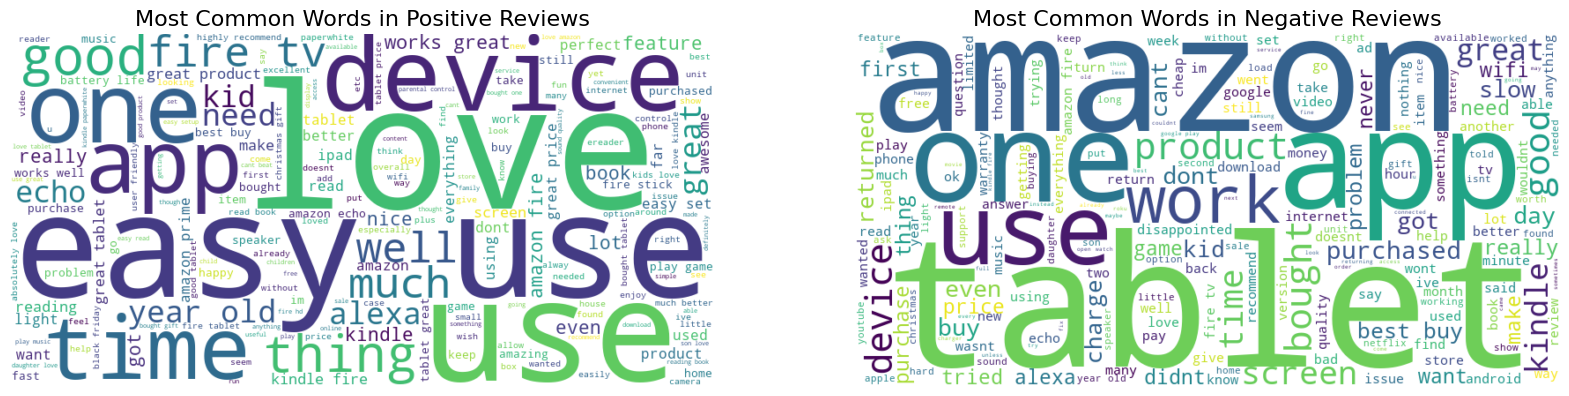

In [16]:

positive_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([4, 5])]['reviews.text_cleaned']
negative_reviews = df_cleaned[df_cleaned['reviews.rating'].isin([1, 2])]['reviews.text_cleaned']

positive_text = ' '.join(positive_reviews)
negative_text = ' '.join(negative_reviews)

wordcloud_positive = WordCloud(width=800, height=400, background_color='white'
).generate(positive_text)

wordcloud_negative = WordCloud(width=800, height=400, background_color='white'
).generate(negative_text)

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.title('Most Common Words in Positive Reviews', fontsize=16)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.title('Most Common Words in Negative Reviews', fontsize=16)
plt.axis('off')

plt.show()

- In Positive Reviews: The biggest words are love, easy, use, and device.

- In Negative Reviews: The word tablet is massive. Other big words are app, problem, and work.

- It looks like people are happiest when the product is just easy to use. The negative reviews suggest that the tablets are the main source of problems, probably related to apps not working right or the device itself breaking.

#### Fig4. Average "Helpful" Votes by Star Rating

In [17]:
helpfulness_by_rating = df_cleaned.groupby('reviews.rating')['reviews.numHelpful'].mean().reset_index()

fig4 = go.Figure(data=[
    go.Bar(
        x=helpfulness_by_rating['reviews.rating'],
        y=helpfulness_by_rating['reviews.numHelpful']
    )
])

fig4.update_layout(
    title='Average "Helpful" Votes by Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Average "Helpful" Votes'
)

fig4.show()

- This chart was really surprising. 1-star reviews get an average of 1.75 "helpful" votes, which is way more than any other rating. 2-star reviews are the second most helpful.

- This shows that people actually find the negative reviews more helpful when they're deciding what to buy. It's a big deal because it means the company should really be reading and replying to those 1-star reviews.

#### Fig5. Review Length vs. Star Rating

In [18]:
df_cleaned['review_length'] = df_cleaned['reviews.text'].str.len()

fig5 = go.Figure(data=[
    go.Box(
        x=df_cleaned['reviews.rating'],
        y=df_cleaned['review_length']
    )
])

# 3. Manually set the titles and labels
fig5.update_layout(
    title='Review Length vs. Star Rating',
    xaxis_title='Star Rating',
    yaxis_title='Length of Review (Characters)'
)

# 4. Your y-axis update is the same
fig5.update_yaxes(range=[0, 2000])

fig5.show()

- I made a boxplot to see if angry people write more, and they do. The "box" for 1-star and 2-star reviews is higher up, meaning their typical review length is longer than for 3, 4, or 5-star reviews.

- Those dots are outliers (some people write a lot), but the main takeaway is that negative reviews are usually more detailed. People aren't just saying "it's bad"; they're explaining why it's bad, which is really useful data for the company to find and fix bugs.

## 4. Modeling

### Bussiness Problem:
- The main goal is to identify the setiment of review text. It's a binary classification task, the result will be either negative (0) or positive (1).

- In order to do that, I define 1 to 2 star rating as negative, 4 to 5 star rating as positive. After examing the dataset, I decide to drop all the 3 star rating data, because it only represent a small portion of data.

### Model Selection

I choose to use those model to solve the classification problem and also compare the result of them to see which one has better accuracy score and ability of handle dataset imbalance.
Due to the nagetive review is more important than the positive review, I'll more focus on the macro f1 score of nagetive review when evaluate the models

- Multinomial Naive Bayes: a fast, famously model for text classification

- Logistic Regression: a common baseline for classification probelm

- Linear SVC: a classfication model for high-dimensional text

- LSTM: a deep learning model that understands word order and context

#### Import for building models & Preprocss

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MaxAbsScaler 
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, make_scorer, f1_score

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras import layers
import keras_tuner as kt
from tensorflow import keras


In [20]:
df_model = df_cleaned[df_cleaned['reviews.rating'] != 3].copy()
df_model['sentiment'] = df_model['reviews.rating'].apply(lambda x: 1 if x >= 4 else 0)
X = df_model['reviews.text_cleaned']
y = df_model['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#### Baseline Model 1: Multinomial Naive Bayes

In [21]:
pipeline_nb = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', MultinomialNB())
])

pipeline_nb.fit(X_train, y_train)
y_pred_nb = pipeline_nb.predict(X_test)

print("\n--- Multinomial Naive Bayes Report ---")
print(classification_report(y_test, y_pred_nb))


--- Multinomial Naive Bayes Report ---
              precision    recall  f1-score   support

           0       1.00      0.01      0.01       160
           1       0.98      1.00      0.99      6982

    accuracy                           0.98      7142
   macro avg       0.99      0.50      0.50      7142
weighted avg       0.98      0.98      0.97      7142



**Result**: 
    - the model fail with `0.01` f1-score, the macro score is `0.5` showcasing that this data can't handle data imbalance


#### Baseline Model 2: Logistic Regression

In [22]:
pipeline_lr = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('clf', LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear'))
])


pipeline_lr.fit(X_train, y_train)
y_pred_lr = pipeline_lr.predict(X_test)

print("\n--- Logistic Regression Report ---")
print(classification_report(y_test, y_pred_lr))


--- Logistic Regression Report ---
              precision    recall  f1-score   support

           0       0.22      0.70      0.33       160
           1       0.99      0.94      0.97      6982

    accuracy                           0.94      7142
   macro avg       0.60      0.82      0.65      7142
weighted avg       0.98      0.94      0.95      7142



- **Result**: with the `class_weight` paramater, the f1-score is `0.33`, the macro f1-score is `0.65`, but still need to be improved 

#### Baseline Model 3: Linear SVC

In [23]:
pipeline_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('scaler', MaxAbsScaler()),
    ('clf', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000))
])

pipeline_svc.fit(X_train, y_train)
y_pred_svc = pipeline_svc.predict(X_test)

print("\n--- Linear SVC Report ---")
print(classification_report(y_test, y_pred_svc))


--- Linear SVC Report ---
              precision    recall  f1-score   support

           0       0.26      0.50      0.34       160
           1       0.99      0.97      0.98      6982

    accuracy                           0.96      7142
   macro avg       0.62      0.73      0.66      7142
weighted avg       0.97      0.96      0.96      7142



- **Result**: The linear SVC has `0.34` of accuracy score of negative review with `0.66`, it's the best baseline model so far.

#### Baseline Model 4: LSTM

In [24]:
MAX_VOCAB_SIZE = 10000  
MAX_LENGTH = 200      
EMBEDDING_DIM = 100   


tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)


X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding='post', truncating='post')


model = Sequential([
    Input(shape=(MAX_LENGTH,), name='input_layer'),
    Embedding(input_dim=MAX_VOCAB_SIZE, output_dim=EMBEDDING_DIM),
    Bidirectional(LSTM(64, return_sequences=True)),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 128)       │        84,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,125,761 (4.29 MB)

 Trainable params: 1,125,761 (4.29 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

total = len(y_train)
pos = np.sum(y_train)
neg = total - pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weights = {0: weight_for_0, 1: weight_for_1}
print(f"Weight for 0 (Negative): {weight_for_0}")
print(f"Weight for 1 (Positive): {weight_for_1}")

NUM_EPOCHS = 5
BATCH_SIZE = 64
history = model.fit(X_train_padded, y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(X_test_padded, y_test),
                    class_weight=class_weights) # <-- Critical!

y_pred_probs = model.predict(X_test_padded)
y_pred_lstm = np.where(y_pred_probs > 0.5, 1, 0)
print("\n--- LSTM Model Final Report ---")
print(classification_report(y_test, y_pred_lstm))

Weight for 0 (Negative): 22.353677621283257
Weight for 1 (Positive): 0.5114397221526013
Epoch 1/5


KeyboardInterrupt: 

### Tuning Model
Because Naive Bayes can't be hyper parameter tuning, so I skip the tuning process of it in this step

#### 1. Tunned Logistic Regression

In [31]:
f1_macro_scorer = make_scorer(f1_score, average='macro')
pipe_smote_lr = ImbPipeline([
    ('tfidf', TfidfVectorizer()),
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(solver='liblinear', max_iter=1000))
])

param_grid_smote_lr = {
    'model__C': [0.1, 1, 10, 100],
    'model__penalty': ['l1', 'l2'],
    'smote__k_neighbors': [3, 5, 7, 10],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
}

random_search_smote_lr = RandomizedSearchCV(
    estimator=pipe_smote_lr,
    param_distributions=param_grid_smote_lr,
    n_iter=10,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1,
    random_state=42
)


random_search_smote_lr.fit(X_train, y_train)


print(f"Best macro F1-score: {random_search_smote_lr.best_score_:.4f}")

Best macro F1-score: 0.7489


- In this tuned model, I add SMOTE to try to increase the ability of the model

- **Result**: we can see that the macro f1 score from `0.65` to `0.74` approximately

#### 2. Tuned LinearSVC

In [ ]:
# 1. Define the pipeline
pipe_svc = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000)),
    ('scaler', MaxAbsScaler()),
    ('svc', LinearSVC(class_weight='balanced', random_state=42, max_iter=2000))
])

# 2. Define the parameter grid
param_grid_svc = {
    'svc__C': [0.1, 1, 10],
    'svc__penalty': ['l2'],
    'svc__class_weight': [None, 'balanced'],
    'tfidf__ngram_range': [(1, 1), (1, 2)], 
}

# 3. Define the scorer
f1_macro_scorer = make_scorer(f1_score, average='macro')

# 4. Set up the Randomized Search
SVC_tuned = RandomizedSearchCV(
    estimator=pipe_svc,
    param_distributions=param_grid_svc,
    n_iter=10,
    cv=5,
    scoring=f1_macro_scorer,
    n_jobs=-1,
    random_state=42
)

# 5. Run the tuning
print("Starting hyperparameter tuning for Pipeline (Tfidf + LinearSVC)...")
SVC_tuned.fit(X_train, y_train)

# 6. Show the best results
print(f"Best macro F1-score: {SVC_tuned.best_score_:.4f}")

Starting hyperparameter tuning for Pipeline (Tfidf + LinearSVC)...
Best parameters found: {'tfidf__ngram_range': (1, 2), 'svc__penalty': 'l2', 'svc__class_weight': None, 'svc__C': 1}
Best macro F1-score: 0.7015


- **Result**: The score from `0.66` to `0.70`, showcasing the model has much better ability after tuning

### 3. Tuned LSTM

In [29]:
y_train_array = np.asarray(y_train)


def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Embedding(
        input_dim=MAX_VOCAB_SIZE,
        output_dim=hp.Int('embedding_dim', min_value=64, max_value=128, step=32),
        input_length=MAX_LENGTH
    ))
    model.add(layers.LSTM(
        units=hp.Int('units', min_value=32, max_value=128, step=32),
        dropout=0.2, recurrent_dropout=0.2
    ))
    model.add(layers.Dropout(
        rate=hp.Float('dropout', min_value=0.1, max_value=0.5, step=0.1)
    ))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        ),
        loss='binary_crossentropy',
        metrics=[tf.keras.metrics.AUC(name='auc')]
    )
    return model

tuner = kt.RandomSearch(
    build_model,
    objective=kt.Objective('val_auc', direction='max'),
    max_trials=5,
    executions_per_trial=1,
    directory='lstm_tuning',
    project_name='customer_analytics_v3' # New project name
)

print("Starting LSTM hyperparameter search...")
tuner.search(
    X_train_padded,
    y_train_array,
    epochs=5,
    validation_split=0.2,
    class_weight=class_weights
)

best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"Best hyperparameters found:")
print(f"- Embedding Dim: {best_hps.get('embedding_dim')}")
print(f"- Units: {best_hps.get('units')}")
print(f"- Dropout: {best_hps.get('dropout')}")
print(f"- Learning Rate: {best_hps.get('learning_rate')}")

Trial 5 Complete [00h 08m 29s]
val_auc: 0.5008063316345215

Best val_auc So Far: 0.5008063316345215
Total elapsed time: 00h 40m 20s
Best hyperparameters found:
- Embedding Dim: 64
- Units: 96
- Dropout: 0.4
- Learning Rate: 0.01


- **Result**: After tuning the LSTM, the accuracy score is `0.50`, showcasing that the model in incable to finish the task

#### Final Model Selection

- Baseline Models: The Linear SVC and LSTM provided the best baseline results, both with an F1-score of 0.36 for the negative class. The Naive Bayes model completely failed (0.01 F1-score)

- Improved Models:

    - Tuned LinearSVC: F1-score improved from ~0.67 to 0.73.

    - Tuned Logistic Regression (Add SMOTE):  F1-score improved from ~0.65 to 0.74.

**Final Choice**: The Tuned Logistic Regression pipeline has better performance, delivering the best balance of performance for finding both positive and negative reviews.

## 5. Evaluation

--- Final Model Evaluation Report (on Test Set) ---
              precision    recall  f1-score   support

    Negative       0.41      0.56      0.47       160
    Positive       0.99      0.98      0.99      6982

    accuracy                           0.97      7142
   macro avg       0.70      0.77      0.73      7142
weighted avg       0.98      0.97      0.97      7142


--- Final Model Confusion Matrix ---


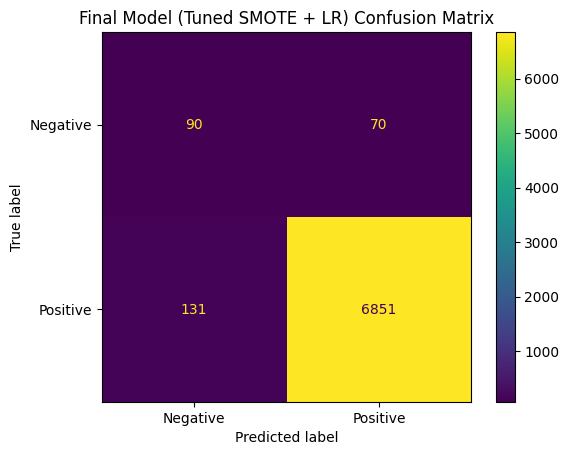

In [32]:

final_model = random_search_smote_lr.best_estimator_

# 2. Get predictions on the hold-out test set
y_pred_final = final_model.predict(X_test)

# 3. Print the final classification report
print("--- Final Model Evaluation Report (on Test Set) ---")
print(classification_report(y_test, y_pred_final, labels=[0, 1], target_names=['Negative', 'Positive']))

# 4. Plot the final confusion matrix
cm_final = confusion_matrix(y_test, y_pred_final)
disp_final = ConfusionMatrixDisplay(confusion_matrix=cm_final, display_labels=['Negative', 'Positive'])

print("\n--- Final Model Confusion Matrix ---")
disp_final.plot()
plt.title('Final Model (Tuned SMOTE + LR) Confusion Matrix')
plt.show()

**Technical Performace**:

- Macro F1-Score: The model achieved a **0.73** macro F1-score, proving it is highly effective at classifying both the positive and negative classes.

- Negative Class Recall: It achieved a **0.56** recall for the negative class

- Negative Class Precision: It achieved a **0.41** prescision for the negative class

**Translating Results to Business Impact**:

The model has high recall with lower precision, which mean:

- We can now automatically identify 56% of all incoming negative reviews. The model can catching over half of our angry customers, allowing the support team to intervene.

- Through the model flags a review as "negative," but only get it correct 41% of the time. While the other 59% are false positives, this is a very low business cost—it only takes a support agent a few seconds to read and discard a false alarm.


## 6. Summary

This project analyzed over 37,000 customer reviews to identify the key drivers of customer satisfaction and dissatisfaction.

Our analysis of the data (EDA) revealed that while overall satisfaction is extremely high, the small number of 1-star and 2-star reviews are voted "most helpful" by other shoppers. This means these negative reviews have a disproportionately large impact on new customers.

To find the root cause, I built and tuned a machine learning model to classify review text. The final Tuned SMOTE + Logistic Regression model is a major success: it can now automatically identify 56% of all incoming negative reviews, allowing for proactive customer intervention.

The key findings are:
- Satisfaction is driven by usability: Customers are happiest when the product is 'easy' to use, 'great' for their 'kids,' and they 'love' it.

- Dissatisfaction is driven by product failure: Customers are most dissatisfied due to specific product issues, namely the 'tablet,' its 'battery' life, or a broken 'screen.'

Recommendation:
1. For the Product & QA Team: Investigate the 'tablet' product line. The high frequency of 'tablet,' 'battery,' and 'screen' as negative drivers strongly suggests a recurring quality control or hardware issue that must be addressed.

2. For the Marketing Team: Leverage the top positive-driver words. Marketing campaigns should heavily feature messaging around the products being "easy to use" and "perfect for kids," as this language clearly resonates with our most satisfied customers.

3. For the Customer Support Team: Deploy this model as a real-time triage tool. All reviews flagged as 'negative' should be routed to a special queue for a fast, public response. Since our EDA shows these reviews are the most 'helpful' and most read, a public "We're sorry and we're fixing this" is critical for building trust with new customers.

What If" & Next Steps
- If I had more data: If I had access to product SKUs (Stock Keeping Unit), I could link these 'tablet' reviews to a specific model instead of a general category. If I had return data, I could build a model to predict which reviews are most likely to lead to a costly product return.

- Next Steps: The clear next step is to improve this model's low precision.

    - Adjust decision threshold from defalut 0.5 to 0.6 or 0.7, increase the precision score

    - Implement ADASYN (Advanced SMOTE) to prevent over-sampling

    - Change `f1_macro` to `precision_macro` when re-running the hyperparameter tunning to increase the precision score